# Mean SST per region
# PDF of different models for DV8

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_functions import *
# Visualization packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

/home/b/b382616/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36379 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-advanced//proxy/36379/status,
Dashboard: /user/b382616/levante-spawner-advanced//proxy/36379/status,Workers: 32
Total threads: 32,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34353,Workers: 32
Dashboard: /user/b382616/levante-spawner-advanced//proxy/36379/status,Total threads: 32
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:38207,Total threads: 1
Dashboard: /user/b382616/levante-spawner-advanced//proxy/46223/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:42681,


# LOAD DATA
## and convert icon longitudes from 0->360 to -180->180

In [ ]:
# OSTIA ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ossta=ds['dat_anomaly']

# OSTIA BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_track_1982_2014_maxanom5_mask70_bugfixed.zarr'
oblobs = xr.open_zarr(str(file_name), chunks={})


In [ ]:
# ICON HIST ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
i_ds = xr.open_zarr(str(file_name), chunks=chunks)
issta=i_ds['dat_anomaly']



# ICON HIST BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_track_1982_2014_maxanom5_mask70_oct25.zarr'
iblobs = xr.open_zarr(str(file_name), chunks={})


In [10]:
#CHECK ICON!!!!


# Check if grids are different
print("OSTIA grid:")
print(f"  Lat: {ds.lat.min().values:.2f} to {ds.lat.max().values:.2f}, {len(ds.lat)} points")
print(f"  Lon: {ds.lon.min().values:.2f} to {ds.lon.max().values:.2f}, {len(ds.lon)} points")

print("ICON grid:")
print(f"  Lat: {i_ds.lat.min().values:.2f} to {i_ds.lat.max().values:.2f}, {len(i_ds.lat)} points")
print(f"  Lon: {i_ds.lon.min().values:.2f} to {i_ds.lon.max().values:.2f}, {len(i_ds.lon)} points")

print("ICON blobs grid:")
print(f"  Lat: {iblobs.lat.min().values:.2f} to {iblobs.lat.max().values:.2f}, {len(iblobs.lat)} points")
print(f"  Lon: {iblobs.lon.min().values:.2f} to {iblobs.lon.max().values:.2f}, {len(iblobs.lon)} points")



OSTIA grid:
  Lat: -89.88 to 89.88, 720 points
  Lon: -179.88 to 179.88, 1440 points
ICON grid:
  Lat: -90.00 to 90.00, 721 points
  Lon: 0.00 to 359.75, 1440 points


In [ ]:

def lon_180w_180e(ds_sice: xr.DataArray):
    ds_sice = (
        ds_sice
        .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)
        .sortby('lon'))

    return ds_sice

i_ds=lon_180w_180e(i_ds)
iblobs=lon_180w_180e(iblobs)

In [3]:
#SST

# OSTIA
time_chunksize = 1000
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.observations.OSTIA.OSTIA.daily']#-output'][model][expid][version]['ocean'][gridspec]
sst = dat.to_dask()
sst=sst['sst'].astype(np.float32).coarsen(lat=5, lon=5,boundary='pad').mean()
sst=sst.chunk(chunks={'time':30, 'lat':-1, 'lon':-1})
sst=sst.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))
sst=sst-273.15

# ICON HISTORICAL
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_ic = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':30, 'lat':-1, 'lon':-1})
sst_ic=sst_ic.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))

# IFS FESOM
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.ifs-fesom2-sr.hist-1950.v20240304.ocean.gr025']#.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_f = dat['2D_daily_avg_1950-2014'].to_dask().avg_tos.isel(depth=0).drop_vars('depth').chunk({'time':30, 'lat':'auto', 'lon':'auto'})
sst_f=sst_f.sel(time=slice('1982-01-01T12:00:00.000000000','2014-12-31T00:00:00.000000000'))
            


# Define regions

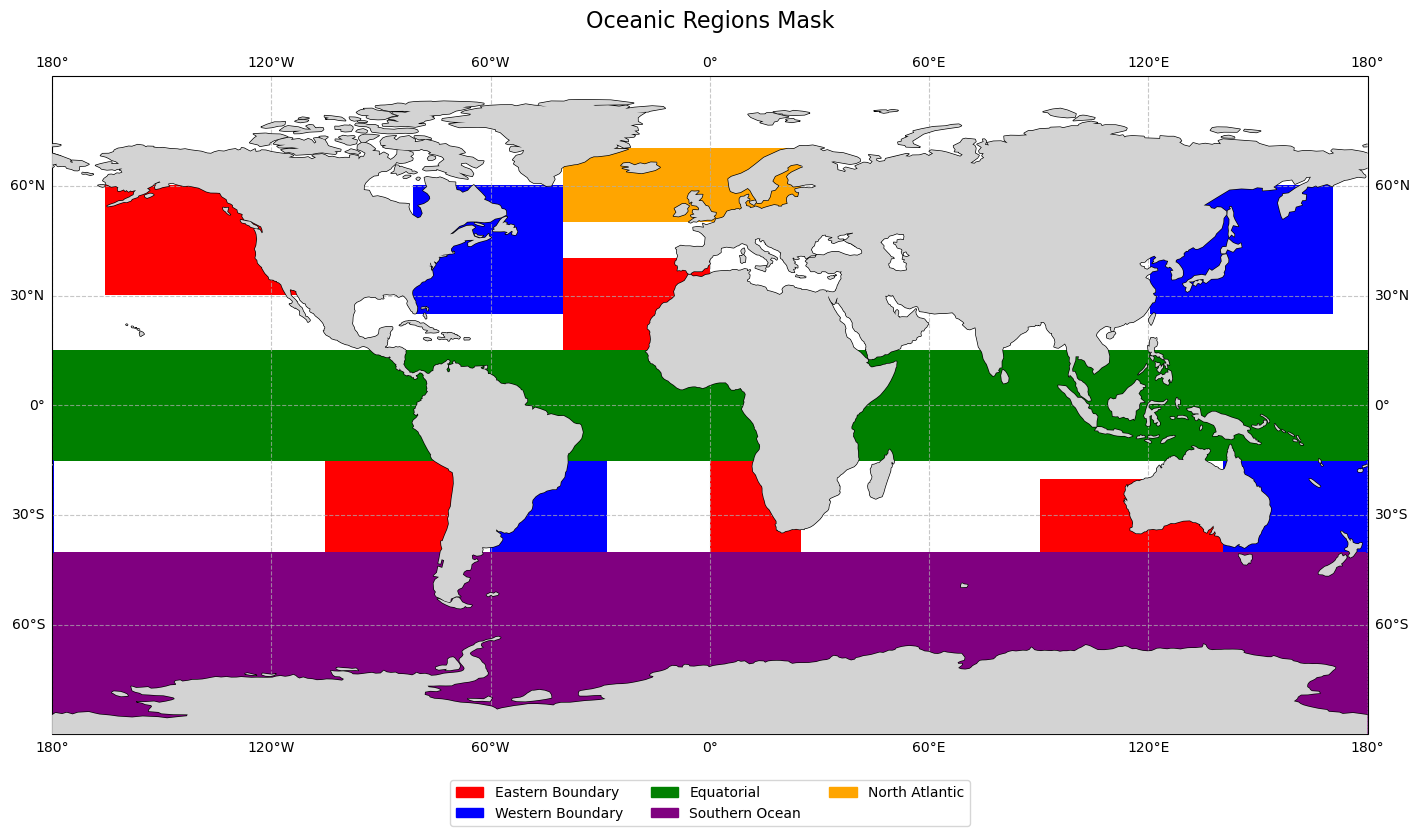

Region Coverage Statistics:
Equatorial          : 10,800 points ( 16.7%)
Southern Ocean      : 18,000 points ( 27.8%)
Eastern Boundary    :  5,200 points (  8.0%)
Western Boundary    :  4,985 points (  7.7%)
North Atlantic      :  1,300 points (  2.0%)
Total               : 64,800 points (100.0%)


In [4]:
# PLOT REGION MASKS
from DV8_functions import *


# Create a sample grid that matches your data resolution
lats = np.linspace(-90, 90, 180)  # Adjust based on your data
lons = np.linspace(-180, 180, 360)  # Adjust based on your data

# Create the masks - NOW WITH PARAMETERS!
masks = create_oceanic_regions_mask(lats, lons)

# Plot the regions to verify
fig, ax = plot_region_masks(lats, lons, masks)#, title="Oceanic Regions for SSTA Analysis")
plt.show()

# Print some statistics about the regions
print("Region Coverage Statistics:")
print("="*40)
total_points = len(lats) * len(lons)
for region, mask in masks.items():
    region_points = np.sum(mask)
    percentage = (region_points / total_points) * 100
    print(f"{region.replace('_', ' ').title():20}: {region_points:>6,} points ({percentage:5.1f}%)")

print(f"{'Total':20}: {total_points:>6,} points (100.0%)")

# Mean SST by region

In [ ]:
# FOR ONE sst
sst=sst_f
#CREATE MASKS
lats_sst = sst['lat'].values  # length = 720
lons_sst = sst['lon'].values  # length = 1440

masks_sst = create_oceanic_regions_mask(lats_sst, lons_sst)

#CONVERT MASKS TO DASK XARRAYS
mask_da_stacked = xr.concat(
    [xr.DataArray(mask, dims=('lat','lon'), name=region) for region, mask in masks_sst.items()],
    dim='region'
)
mask_da_stacked['region'] = list(masks_sst.keys())

#COMPUTE SST REGIONAL MEANS
sst_expanded = sst.expand_dims({'region': mask_da_stacked.region})
masked_sst = sst_expanded.where(mask_da_stacked)
region_means = masked_sst.mean(dim=('lat','lon'))  # shape: (time, region)


In [ ]:
def compute_region_means(sst_da, mask_da_stacked):
    """
    Compute mean SST per region for a given SST DataArray and stacked masks.
    
    Parameters:
    - sst_da: xarray.DataArray, dims = ('time', 'lat', 'lon')
    - mask_da_stacked: xarray.DataArray, dims = ('region','lat','lon')
    
    Returns:
    - region_means: xarray.DataArray, dims = ('time', 'region')
    """
    # Expand SST to have 'region' dim
    sst_expanded = sst_da.expand_dims({'region': mask_da_stacked.region})
    
    # Apply masks
    masked_sst = sst_expanded.where(mask_da_stacked)
    
    # Compute mean over lat/lon
    region_means = masked_sst.mean(dim=('lat','lon'))
    
    return region_means


In [ ]:
sst_f_interp  = sst_f.interp(lat=sst['lat'], lon=sst['lon'], method='linear')
region_means_fesom = compute_region_means(sst_f_interp, mask_da_stacked)

In [ ]:
# Interpolate ICON and IFS-FESOM to the OSTIA grid
sst_ic_interp = sst_ic.interp(lat=sst['lat'], lon=sst['lon'], method='linear')
sst_f_interp  = sst_f.interp(lat=sst['lat'], lon=sst['lon'], method='linear')

region_means_ostia = compute_region_means(sst, mask_da_stacked)
region_means_icon  = compute_region_means(sst_ic_interp, mask_da_stacked)
region_means_fesom = compute_region_means(sst_f_interp, mask_da_stacked)



In [ ]:
%%time
region_means_icon=region_means_icon.compute()

In [ ]:
region_means_ostia=region_means_ostia.compute()

In [ ]:
region_means_fesom=region_means_fesom.compute()

In [ ]:
region_means_ostia.to_netcdf('region_means_ostia.nc')
region_means_icon.to_netcdf('region_means_icon.nc')

# Clean encoding & attributes on time variable
# Clean encoding & attributes on time variable before saving
if 'time' in region_means_fesom.coords:
    region_means_fesom['time'].encoding.clear()
    region_means_fesom['time'].attrs.pop('units', None)
    region_means_fesom['time'].attrs.pop('calendar', None)

# Save safely
region_means_fesom.to_netcdf('region_means_fesom.nc')



In [4]:
region_means_ostia=xr.open_dataset('region_means_ostia.nc')
region_means_icon=xr.open_dataset('region_means_icon.nc')
region_means_fesom=xr.open_dataset('region_means_fesom.nc')


In [8]:
str(region_means_icon.region.values)

"['equatorial' 'southern_ocean' 'eastern_boundary' 'western_boundary'\n 'north_atlantic']"

In [22]:
# Compute global temporal mean
global_ostia = sst.mean(dim=('time','lat','lon')).values
global_icon  = sst_ic.mean(dim=('time','lat','lon')).values
global_fesom = sst_f.mean(dim=('time','lat','lon')).values

# For OSTIA - compute mean without loading full array
temporal_mean_ostia = region_means_ostia.mean(dim='time')
#temporal_mean_ostia_computed = temporal_mean_ostia.compute()  # This is small - just 5 values

# For ICON - compute mean without loading full array  
temporal_mean_icon = region_means_icon.mean(dim='time')
#temporal_mean_icon_computed = temporal_mean_icon.compute()  # This is small - just 5 values



Exception ignored in: 2025-10-14 15:10:51,103 - distributed.worker_memory - ERROR - 
Traceback (most recent call last):
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loop.run_until_complete(main)
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete
    self.run_forever()
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/asyncio/base_events.py", line 1871, in _run_once
    event_list = self._selector.select(timeout)
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/selectors.py", line 469, in select
    fd_event_list = self._selector.poll(timeout, max_ev)
KeyboardInterrupt

During handling of the above exception, another excepti

KeyboardInterrupt: 

/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/psutil/_pslinux.py", line 1646, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/psutil/_pslinux.py", line 1906, in memory_info
    with open_binary(f"{self._procfs_path}/{self.pid}/statm") as f:
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/psutil/_common.py", line 766, in open_binary
    return open(fname, "rb", buffering=FILE_READ_BUFFER_SIZE)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/multiprocessing/spawn.py", line 129, in _main
    return s

In [19]:
temporal_mean_icon

<xarray.Dataset>
Dimensions:  (region: 5)
Coordinates:
  * region   (region) object 'equatorial' 'southern_ocean' ... 'north_atlantic'
Data variables:
    to       (region) float32 27.4 5.053 19.77 18.97 10.09

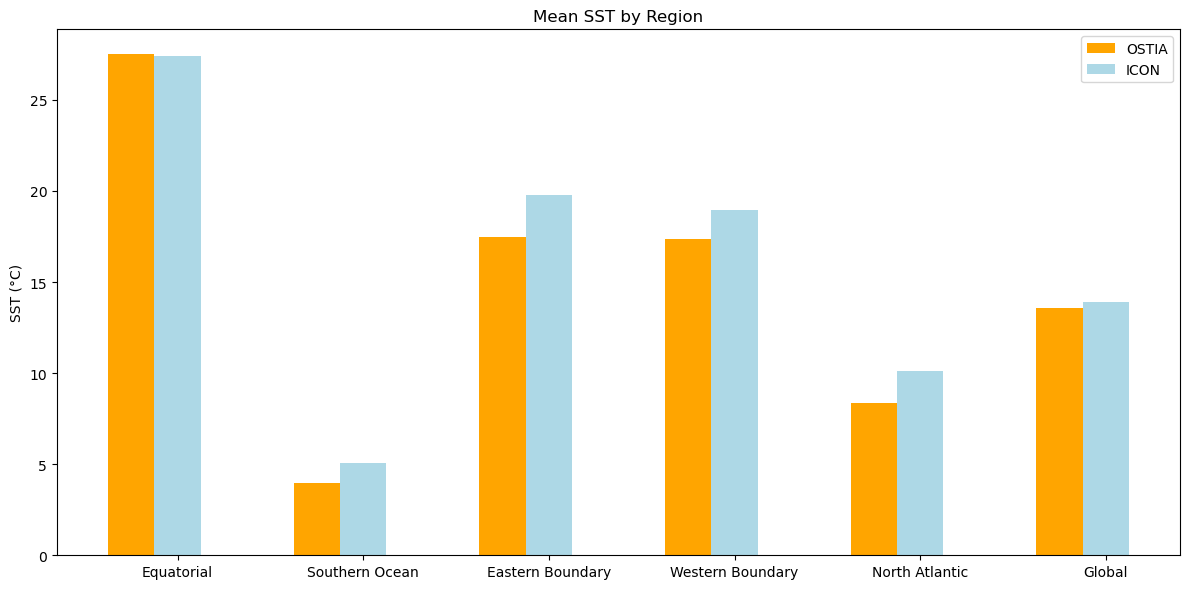

In [21]:


# Append global mean to temporal_mean arrays
all_region_names = list(region_means_icon.region.values) + ['Global']
all_temporal_ostia = np.append(temporal_mean_ostia.sst, global_ostia)
all_temporal_icon  = np.append(temporal_mean_icon.to,  global_icon)
#all_temporal_fesom = np.append(temporal_mean_fesom.avg_tos, global_fesom)

# Now plot as before
x = np.arange(len(all_region_names))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, all_temporal_ostia, width, label='OSTIA', color='orange', alpha=1)
plt.bar(x,         all_temporal_icon,  width, label='ICON', color='lightblue', alpha=1)
#plt.bar(x + width, all_temporal_fesom, width, label='IFS-FESOM', color='lightseagreen', alpha=1)

plt.xticks(x, [r.replace('_',' ').title() for r in all_region_names])
plt.ylabel('SST (°C)')
plt.title('Mean SST by Region')
plt.legend()
plt.tight_layout()
plt.show()


# Mean SSTA by region

In [5]:
# FOR ONE sst
sst=ossta
#CREATE MASKS
lats_sst = sst['lat'].values  # length = 720
lons_sst = sst['lon'].values  # length = 1440

masks_sst = create_oceanic_regions_mask(lats_sst, lons_sst)

#CONVERT MASKS TO DASK XARRAYS
mask_da_stacked_ssta = xr.concat(
    [xr.DataArray(mask, dims=('lat','lon'), name=region) for region, mask in masks_sst.items()],
    dim='region'
)
mask_da_stacked_ssta['region'] = list(masks_sst.keys())

/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [6]:

def compute_region_means(sst_da, mask_da_stacked):
    """
    Compute mean SST per region for a given SST DataArray and stacked masks.
    
    Parameters:
    - sst_da: xarray.DataArray, dims = ('time', 'lat', 'lon')
    - mask_da_stacked: xarray.DataArray, dims = ('region','lat','lon')
    
    Returns:
    - region_means: xarray.DataArray, dims = ('time', 'region')
    """
    # Expand SST to have 'region' dim
    sst_expanded = sst_da.expand_dims({'region': mask_da_stacked.region})
    
    # Apply masks
    masked_sst = sst_expanded.where(mask_da_stacked)
    
    # Compute mean over lat/lon
    region_means = masked_sst.mean(dim=('lat','lon'))
    
    return region_means


# Interpolate ICON and IFS-FESOM to the OSTIA grid
ssta_ic_interp = issta.interp(lat=ossta['lat'], lon=ossta['lon'], method='linear')

region_means_ostia_ssta = compute_region_means(ossta, mask_da_stacked_ssta)
region_means_icon_ssta  = compute_region_means(ssta_ic_interp, mask_da_stacked_ssta)


In [7]:

%%time
region_means_icon_ssta=region_means_icon_ssta.compute()
region_means_ostia_ssta=region_means_ostia_ssta.compute()


2025-10-14 14:30:46,727 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:40047
Traceback (most recent call last):
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
  File "/home/b/b382616/opt/anaconda3/envs/marEx_intake/lib/python3.10/site-packages/distributed/worker.py", line 2878, in get_data_from_worker
   

KilledWorker: Attempted to run task ('dask_aware_interpnd-broadcast_to-f7e393b33e76626e3aec67efff8d912e', 0, 39, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38775. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [13]:

region_means_ostia_ssta.to_netcdf('region_means_ostia_ssta.nc')
region_means_icon_ssta.to_netcdf('region_means_icon_ssta.nc')

# Clean encoding & attributes on time variable
# Clean encoding & attributes on time variable before saving
if 'time' in region_means_fesom.coords:
    region_means_fesom['time'].encoding.clear()
    region_means_fesom['time'].attrs.pop('units', None)
    region_means_fesom['time'].attrs.pop('calendar', None)

# Save safely
#egion_means_fesom.to_netcdf('region_means_fesom.nc')

2025-10-14 14:17:34,664 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.27 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:34,948 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.89 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:35,582 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.20 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:36,934 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:44999
Traceb

KilledWorker: Attempted to run task ('mean_agg-aggregate-mean_chunk-store-map-18330f93da42a074b879ba9b69612250', 0, 20) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:42375. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2025-10-14 14:17:50,627 - distributed.worker.memory - WARNING - Worker is at 85% memory usage. Pausing worker.  Process memory: 6.28 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:50,651 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 6.11 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:50,654 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.94 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:50,965 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.19 GiB -- Worker memory limit: 7.36 GiB
2025-10-14 14:17:50,981 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memo

In [9]:
# For OSTIA - compute mean without loading full array
temporal_mean_ostia = region_means_ostia_ssta.mean(dim='time')
# For ICON - compute mean without loading full array  
temporal_mean_icon = region_means_icon_ssta.mean(dim='time')


In [35]:
def lon_180w_180e(ds_sice: xr.DataArray):
    ds_sice = (
        ds_sice
        .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)
        .sortby('lon'))

    return ds_sice


issta_n=lon_180w_180e(issta)

In [43]:
# ULTRA SIMPLE - Compute means directly from original data
lats = ds.lat.values
lons = ds.lon.values
masks = create_oceanic_regions_mask(lats, lons)


ostia_means = []
icon_means = []

for region_name, mask in masks.items():
    print(f"Computing {region_name}...")
    
    # Create mask DataArray
    mask_da = xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': lats, 'lon': lons})
    
    # OSTIA: Apply mask and compute mean
    ostia_masked = ds['dat_anomaly'].where(mask_da)
    ostia_mean = ostia_masked.mean().compute()
    ostia_means.append(ostia_mean.values)
    
    # ICON: Apply mask and compute mean
    #icon_masked = issta_n.where(mask_da)
    #icon_mean = icon_masked.mean().compute()
    #icon_means.append(icon_mean.values)

temporal_mean_ostia_computed = np.array(ostia_means)



# ULTRA SIMPLE - Compute means directly from original data
lats = i_ds.lat.values
lons = i_ds.lon.values
masks = create_oceanic_regions_mask(lats, lons)


icon_means = []

for region_name, mask in masks.items():
    print(f"Computing {region_name}...")
    
    # Create mask DataArray
    mask_da = xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': lats, 'lon': lons})
    
    
    # ICON: Apply mask and compute mean
    icon_masked = issta.where(mask_da)
    icon_mean = icon_masked.mean().compute()
    icon_means.append(icon_mean.values)

temporal_mean_icon_computed = np.array(icon_means)

Computing equatorial...
Computing southern_ocean...
Computing eastern_boundary...
Computing western_boundary...
Computing north_atlantic...
Computing equatorial...
Computing southern_ocean...
Computing eastern_boundary...
Computing western_boundary...
Computing north_atlantic...


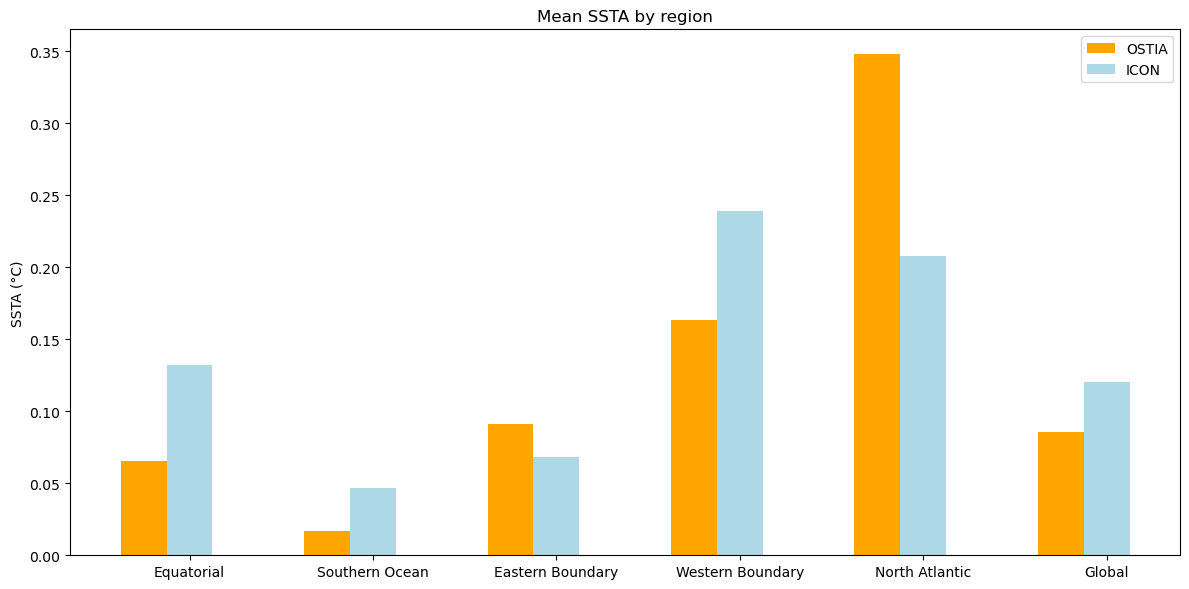

In [47]:

# Compute global temporal mean
global_ostia_ssta = ossta.mean(dim=('time','lat','lon')).values
global_icon_ssta  = issta.mean(dim=('time','lat','lon')).values


# Append global mean to temporal_mean arrays
all_region_names = list(region_names) + ['Global']
all_temporal_ostia = np.append(temporal_mean_ostia_computed, global_ostia_ssta)
all_temporal_icon  = np.append(temporal_mean_icon_computed,  global_icon_ssta)

# Now plot as before
x = np.arange(len(all_region_names))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, all_temporal_ostia, width, label='OSTIA', color='orange', alpha=1)
plt.bar(x,         all_temporal_icon,  width, label='ICON', color='lightblue', alpha=1)

plt.xticks(x, [r.replace('_',' ').title() for r in all_region_names])
plt.ylabel('SSTA (°C)')
plt.title('Mean SSTA by region')
plt.legend()
plt.tight_layout()
plt.show()




# PDFs

Computing PDFs for OSTIA - SST Anomaly


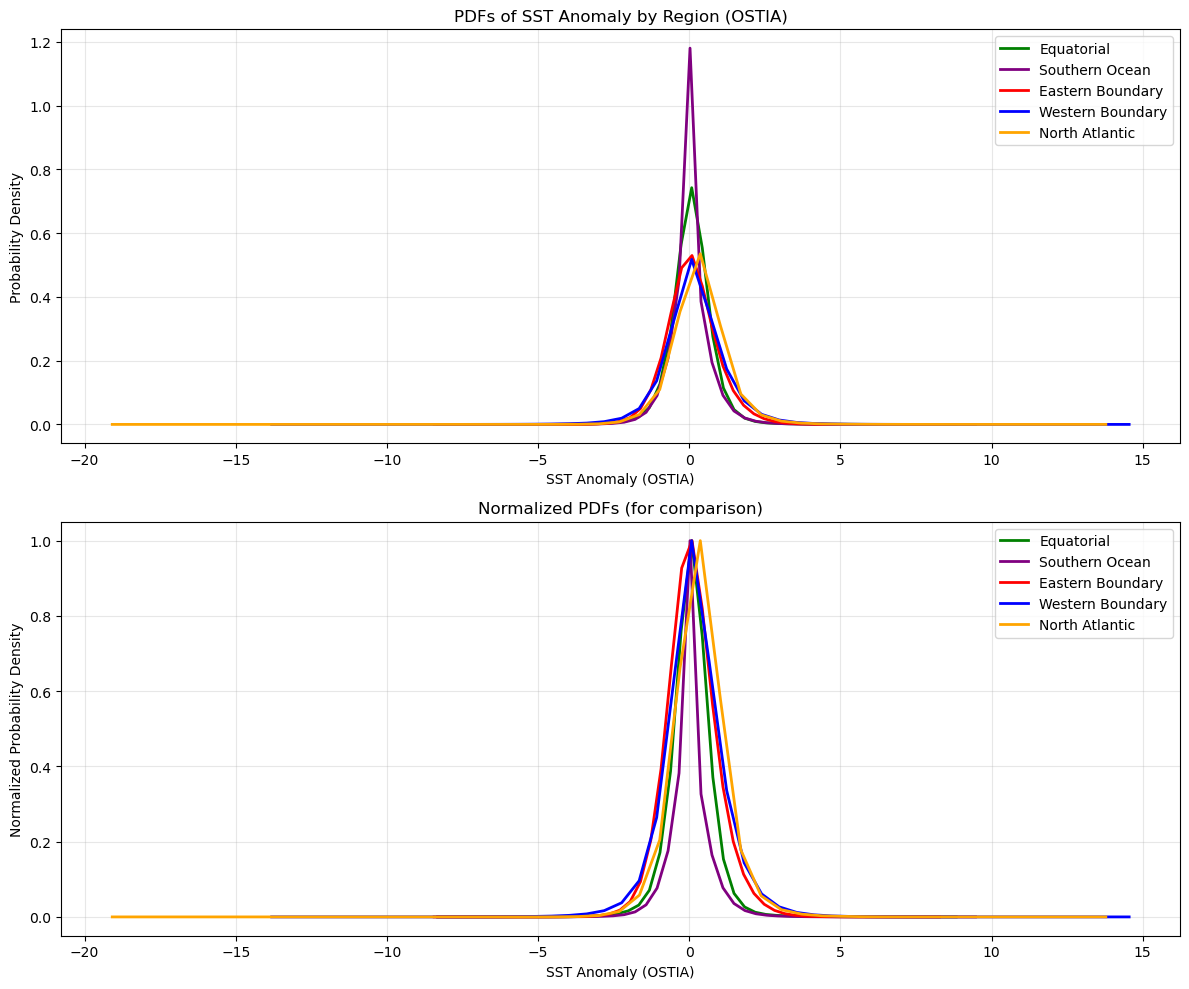

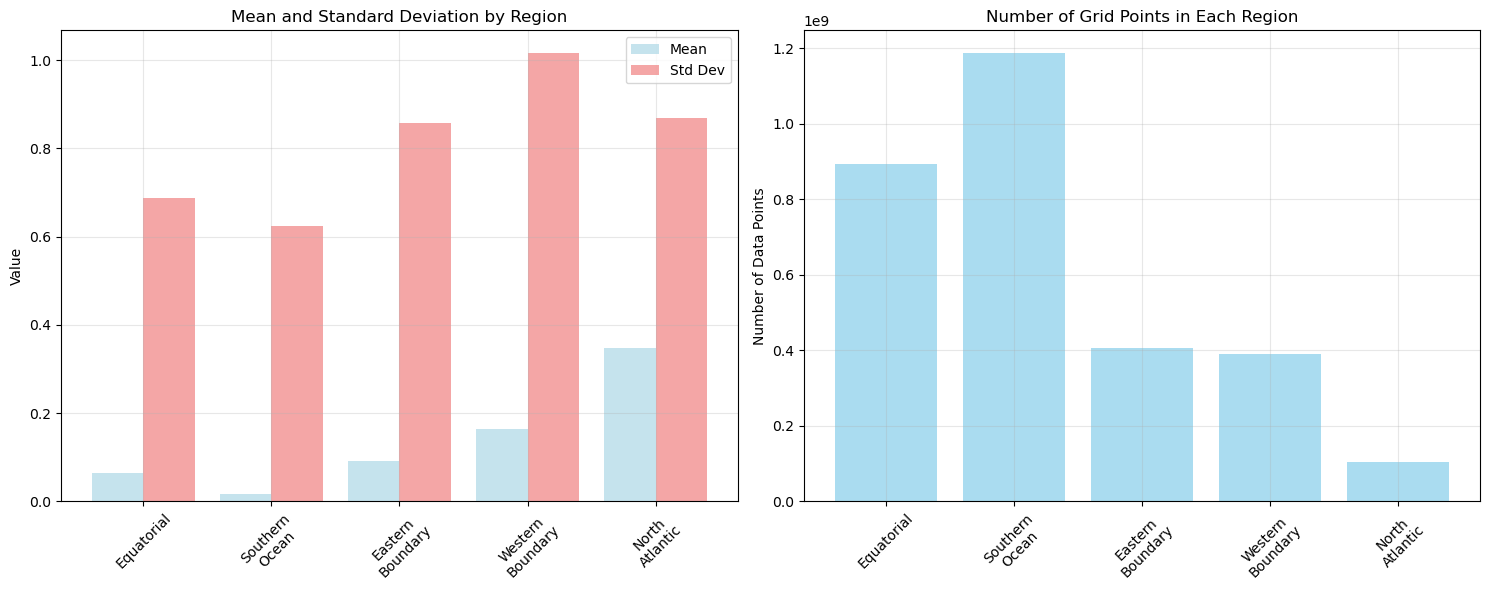


OSTIA - SST Anomaly Region Statistics:
Equatorial           | Mean:   0.065 | Std:  0.687 | Points: 895,314,903
Southern Ocean       | Mean:   0.017 | Std:  0.624 | Points: 1,188,667,893
Eastern Boundary     | Mean:   0.091 | Std:  0.857 | Points: 405,790,728
Western Boundary     | Mean:   0.164 | Std:  1.017 | Points: 391,586,475
North Atlantic       | Mean:   0.348 | Std:  0.869 | Points: 105,437,493
Computing PDFs for OSTIA - Extreme Events


/home/b/b382616/notebooks_home/D8_ocean_extremes_assessment/DV8_functions.py:145: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  counts, bin_edges = np.histogram(clean_data, bins=bins, density=density)


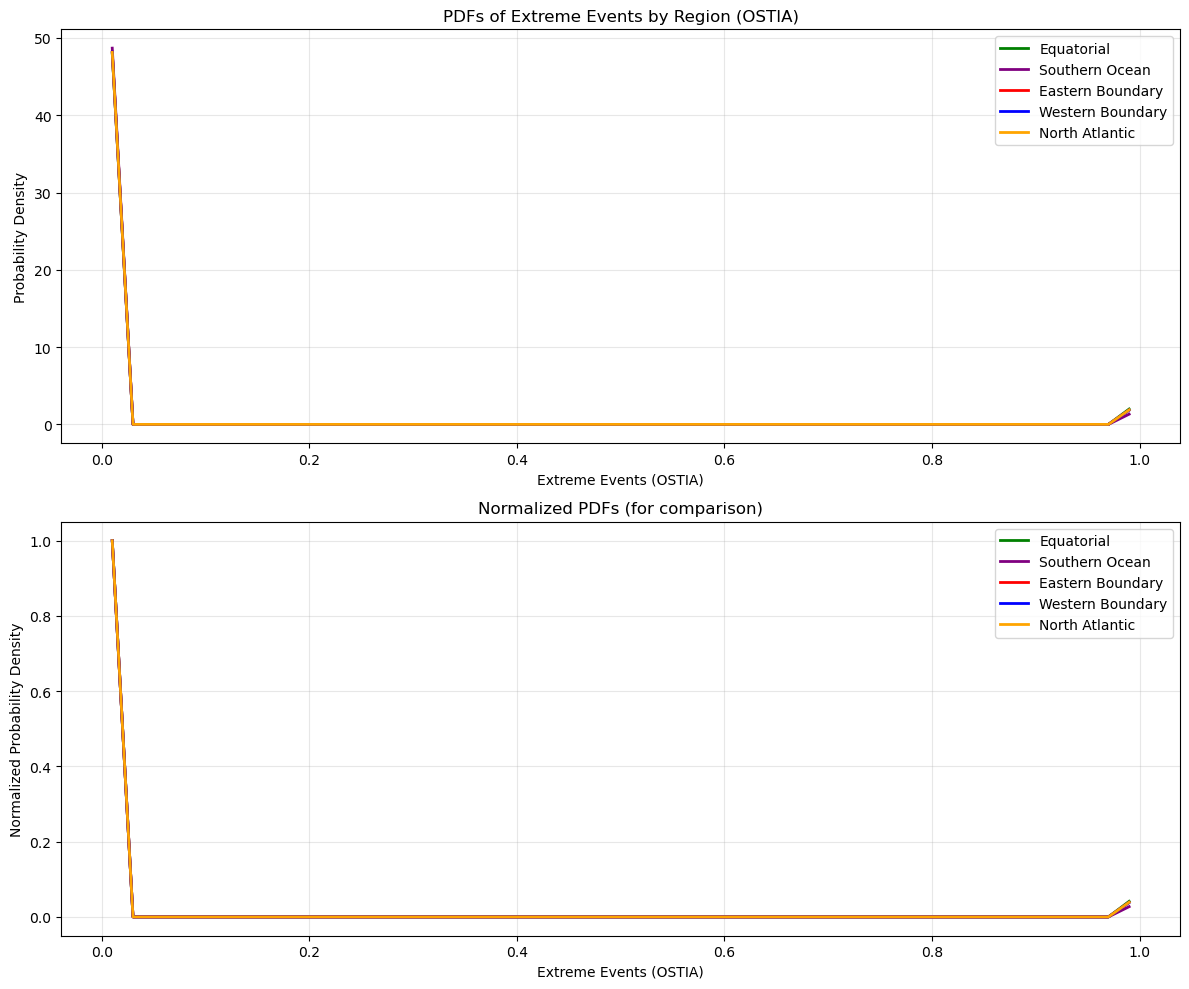

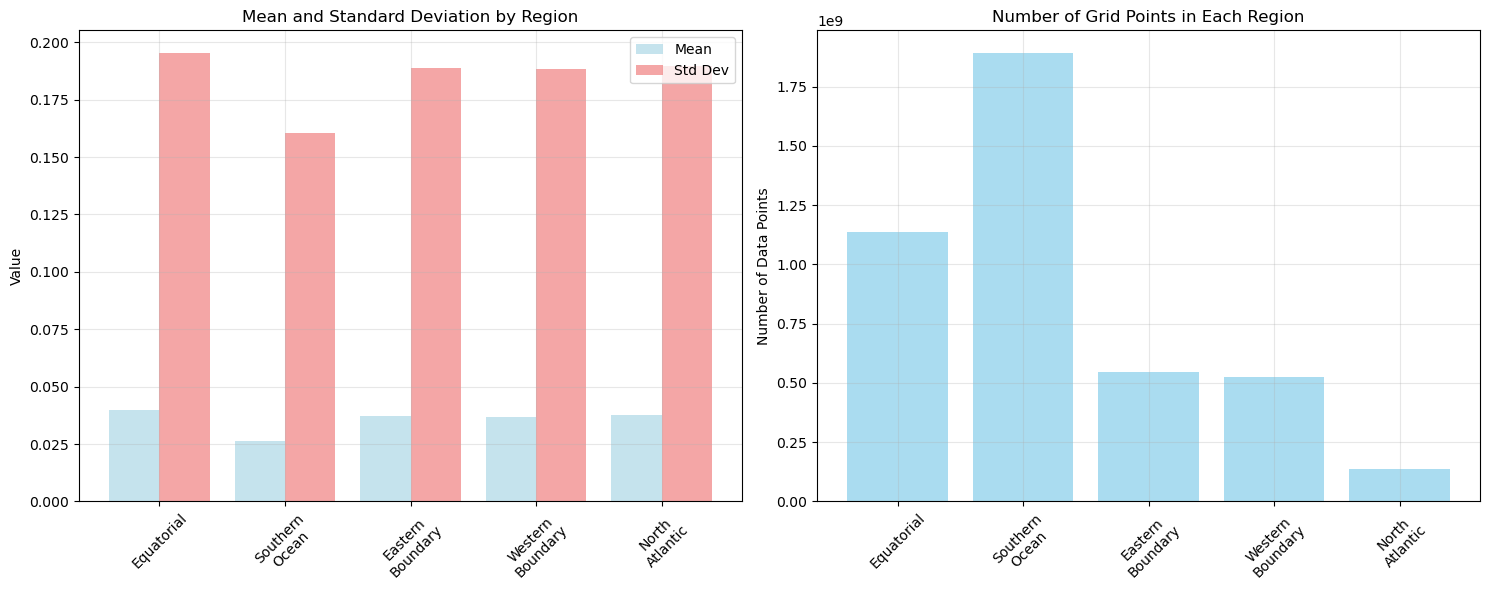


OSTIA - Extreme Events Region Statistics:
Equatorial           | Mean:   0.040 | Std:  0.195 | Points: 1,135,814,400
Southern Ocean       | Mean:   0.027 | Std:  0.161 | Points: 1,893,024,000
Eastern Boundary     | Mean:   0.037 | Std:  0.189 | Points: 546,873,600
Western Boundary     | Mean:   0.037 | Std:  0.188 | Points: 524,262,480
North Atlantic       | Mean:   0.037 | Std:  0.190 | Points: 136,718,400


NameError: name 'icon_anomaly_pdfs' is not defined

In [4]:

# Get coordinates from your data
lats_ostia = ds.lat.values
lons_ostia = ds.lon.values

# Create masks once
masks = create_oceanic_regions_mask(lats_ostia, lons_ostia)

# Compute PDFs for OSTIA SST anomalies
ostia_anomaly_pdfs, ostia_anomaly_stats = compute_pdfs_for_variable(
    ds['dat_anomaly'].values, lats_ostia, lons_ostia, masks, 
    "SST Anomaly", "OSTIA"
)

# Compute PDFs for OSTIA extreme events
ostia_extreme_pdfs, ostia_extreme_stats = compute_pdfs_for_variable(
    ds['extreme_events'].values, lats_ostia, lons_ostia, masks,
    "Extreme Events", "OSTIA"
)


# Compute PDFs for OSTIA SST anomalies
icon_anomaly_pdfs, icon_anomaly_stats = compute_pdfs_for_variable(
    ds_i['dat_anomaly'].values, lats_ostia, lons_ostia, masks, 
    "SST Anomaly", "ICON"
)

# Compute PDFs for OSTIA extreme events
icon_extreme_pdfs, icon_extreme_stats = compute_pdfs_for_variable(
    ds_i['extreme_events'].values, lats_ostia, lons_ostia, masks,
    "Extreme Events", "ICON"
)

# Compare models
compare_models_pdfs(ostia_anomaly_pdfs, icon_anomaly_pdfs, "SST Anomaly (°C)")
compare_models_stats(ostia_anomaly_stats, icon_anomaly_stats, "SST Anomaly")


ANALYZING ICON SST ANOMALIES
Computing PDFs for ICON - SST Anomaly
Trimming 1% from each tail for better visualization


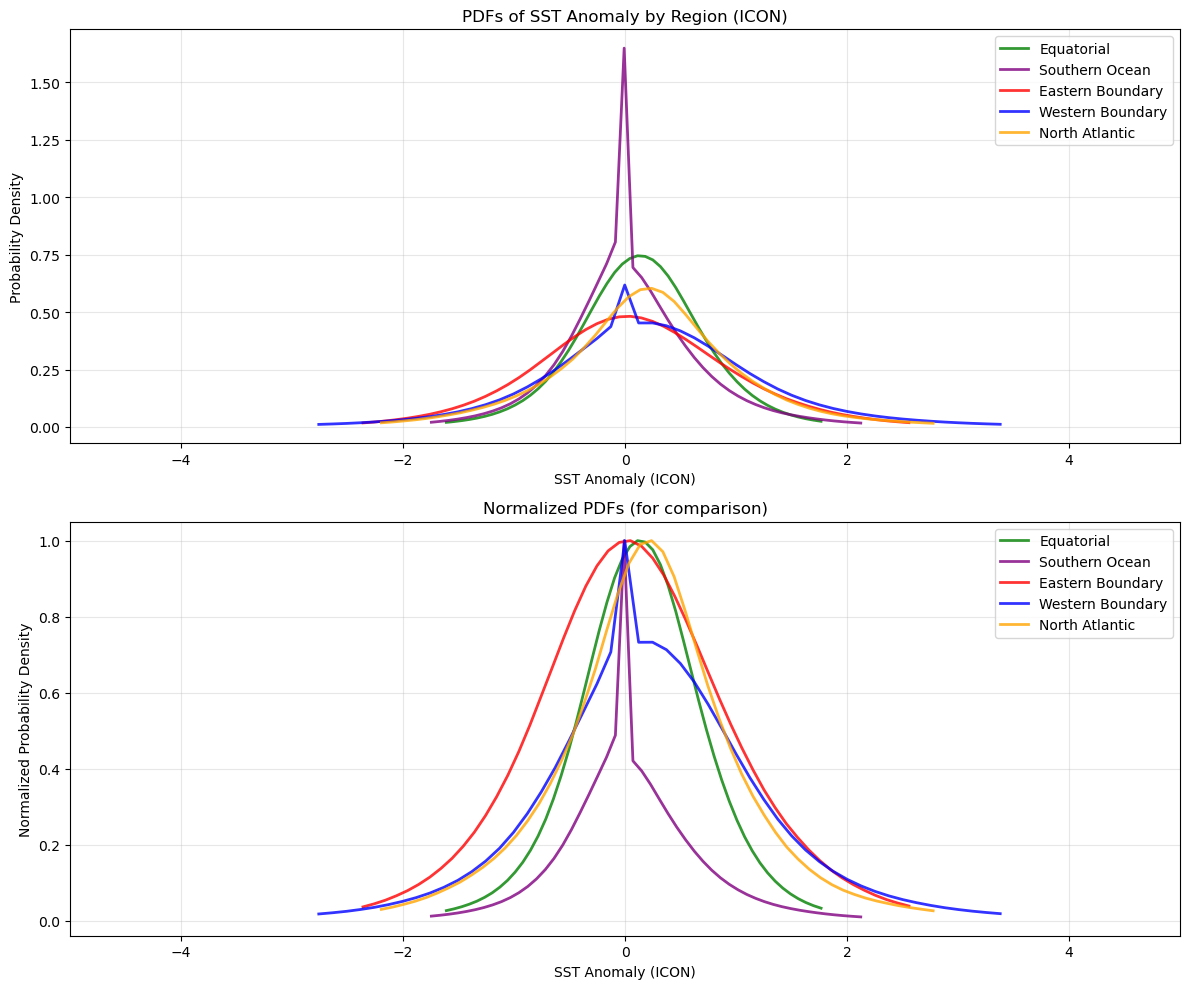

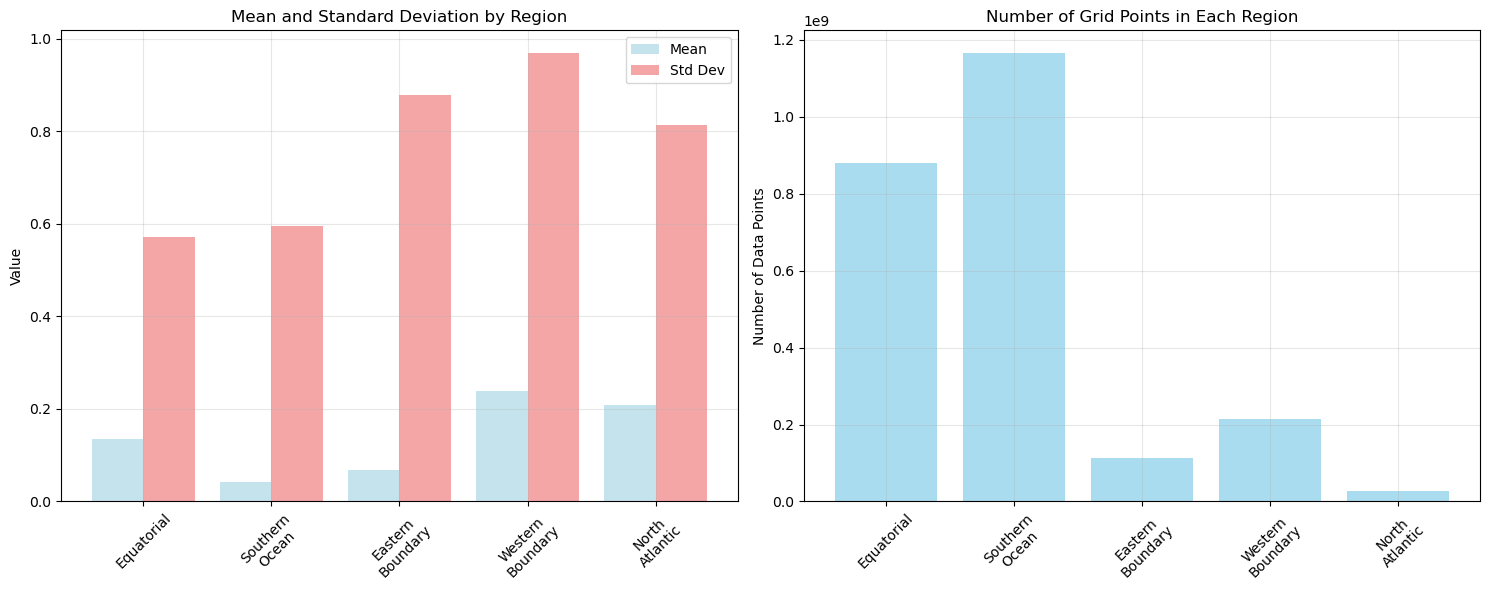


ICON - SST Anomaly Region Statistics:
(Tails trimmed: 1% from each side)
Equatorial           | Mean:   0.135 | Std:  0.571 | Points: 880,191,617
Southern Ocean       | Mean:   0.043 | Std:  0.595 | Points: 1,166,312,190
Eastern Boundary     | Mean:   0.069 | Std:  0.879 | Points: 113,899,337
Western Boundary     | Mean:   0.239 | Std:  0.970 | Points: 214,786,715
North Atlantic       | Mean:   0.207 | Std:  0.814 | Points: 27,067,353


In [4]:
#ICON

# Get ICON coordinates (make sure they're on the same grid as OSTIA)
lats_icon = i_ds.lat.values
lons_icon = i_ds.lon.values

# Create masks for ICON grid (should be same as OSTIA if same grid)
masks_icon = create_oceanic_regions_mask(lats_icon, lons_icon)

# Analyze ICON SST Anomalies
print("\n" + "="*60)
print("ANALYZING ICON SST ANOMALIES")
print("="*60)

icon_anomaly_pdfs, icon_anomaly_stats = compute_pdfs_for_variable_improved(
    i_ds['dat_anomaly'].values, 
    lats_icon, 
    lons_icon, 
    masks_icon,
    variable_name="SST Anomaly", 
    model_name="ICON",
    trim_tails=True,
    tail_percentile=1,  # Trim 1% from each tail
    xlim=(-5, 5)  # Focus on ±5°C range for anomalies
)

In [5]:
print("\n" + "="*60)
print("ANALYZING ICON EXTREME EVENTS")
print("="*60)

icon_extreme_pdfs, icon_extreme_stats = compute_pdfs_for_variable_improved(
    i_ds['extreme_events'].values,
    lats_icon,
    lons_icon, 
    masks_icon,
    variable_name="Extreme Events",
    model_name="ICON", 
    trim_tails=True,
    tail_percentile=0.5,  # Trim less for extremes (they're rare)
    xlim=None  # Let it auto-scale
)


ANALYZING ICON EXTREME EVENTS
Computing PDFs for ICON - Extreme Events
Trimming 0.5% from each tail for better visualization


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
# Compare SST Anomalies between models
print("\n" + "="*60)
print("COMPARING OSTIA vs ICON - SST ANOMALIES")
print("="*60)

compare_models_pdfs(ostia_anomaly_pdfs, icon_anomaly_pdfs, "SST Anomaly (°C)")
compare_models_stats(ostia_anomaly_stats, icon_anomaly_stats, "SST Anomaly")

# Compare Extreme Events between models
print("\n" + "="*60)
print("COMPARING OSTIA vs ICON - EXTREME EVENTS")
print("="*60)

compare_models_pdfs(ostia_extreme_pdfs, icon_extreme_pdfs, "Extreme Events")
compare_models_stats(ostia_extreme_stats, icon_extreme_stats, "Extreme Events")